In [1]:
import pandas as pd

# Load the datasets
amr_data = pd.read_csv('final_AMR_data.csv')
gdp_data = pd.read_csv('gdp_data.csv')
health_expenditure = pd.read_csv('health_expenditure.csv')

# Display the first few rows and general information for each dataset
data_overview = {
    "AMR Data": {"Preview": amr_data.head(), "Info": amr_data.info()},
    "GDP Data": {"Preview": gdp_data.head(), "Info": gdp_data.info()},
    "Health Expenditure Data": {"Preview": health_expenditure.head(), "Info": health_expenditure.info()}
}

data_overview

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16829 entries, 0 to 16828
Data columns (total 15 columns):
 #   Column                                             Non-Null Count  Dtype  
---  ------                                             --------------  -----  
 0   Unnamed: 0                                         16829 non-null  int64  
 1   HealthTopic                                        16829 non-null  object 
 2   Bacteria                                           16829 non-null  object 
 3   Drug_Class                                         16829 non-null  object 
 4   Year                                               16829 non-null  int64  
 5   geo                                                16829 non-null  object 
 6   RegionName                                         16829 non-null  object 
 7   Completeness age_%                                 0 non-null      float64
 8   Completeness gender_%                              0 non-null      float64
 9   I - 's

{'AMR Data': {'Preview':    Unnamed: 0               HealthTopic            Bacteria       Drug_Class   
  0           0  Antimicrobial resistance  Acinetobacter spp.  Aminoglycosides  \
  1           1  Antimicrobial resistance  Acinetobacter spp.  Aminoglycosides   
  2           2  Antimicrobial resistance  Acinetobacter spp.  Aminoglycosides   
  3           3  Antimicrobial resistance  Acinetobacter spp.  Aminoglycosides   
  4           4  Antimicrobial resistance  Acinetobacter spp.  Aminoglycosides   
  
     Year geo RegionName  Completeness age_%  Completeness gender_%   
  0  2012  AT    Austria                 NaN                    NaN  \
  1  2012  BE    Belgium                 NaN                    NaN   
  2  2012  BG   Bulgaria                 NaN                    NaN   
  3  2012  CY     Cyprus                 NaN                    NaN   
  4  2012  CZ    Czechia                 NaN                    NaN   
  
     I - 'susceptible, increased exposure' isolates _

In [2]:
# Cleaning the AMR Data
# Removing unnecessary columns and handling missing values and data types
amr_data_clean = amr_data.drop(columns=['Unnamed: 0', 'Completeness age_%', 'Completeness gender_%'])
amr_data_clean['Penicillin non-wild-type isolates, percentage_%'] = pd.to_numeric(
    amr_data_clean['Penicillin non-wild-type isolates, percentage_%'].str.replace('%', ''), errors='coerce')
amr_data_clean['R - resistant isolates, percentage  _%'] = pd.to_numeric(
    amr_data_clean['R - resistant isolates, percentage  _%'].str.replace('%', ''), errors='coerce')

# Drop columns with high percentage of missing values and fill the rest with zeros or appropriate values
amr_data_clean = amr_data_clean.drop(columns=['I - \'susceptible, increased exposure\' isolates _N'])
amr_data_clean = amr_data_clean.fillna(0)

# Cleaning the GDP Data
gdp_data_clean = gdp_data.drop(columns=['Unnamed: 0'])
gdp_data_clean['CP_EUR_HAB'] = gdp_data_clean['CP_EUR_HAB'].fillna(gdp_data_clean['CP_EUR_HAB'].mean())

# Cleaning the Health Expenditure Data
health_expenditure_clean = health_expenditure.drop(columns=['Unnamed: 0'])
health_expenditure_clean = health_expenditure_clean.fillna(health_expenditure_clean.mean(numeric_only=True))

# Display cleaned data
cleaned_data_overview = {
    "AMR Data Cleaned": {"Preview": amr_data_clean.head(), "Info": amr_data_clean.info()},
    "GDP Data Cleaned": {"Preview": gdp_data_clean.head(), "Info": gdp_data_clean.info()},
    "Health Expenditure Cleaned": {"Preview": health_expenditure_clean.head(), "Info": health_expenditure_clean.info()}
}

cleaned_data_overview


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16829 entries, 0 to 16828
Data columns (total 11 columns):
 #   Column                                           Non-Null Count  Dtype  
---  ------                                           --------------  -----  
 0   HealthTopic                                      16829 non-null  object 
 1   Bacteria                                         16829 non-null  object 
 2   Drug_Class                                       16829 non-null  object 
 3   Year                                             16829 non-null  int64  
 4   geo                                              16829 non-null  object 
 5   RegionName                                       16829 non-null  object 
 6   Penicillin non-wild-type isolates, percentage_%  16829 non-null  float64
 7   R - resistant isolates_N                         16829 non-null  float64
 8   R - resistant isolates, percentage  _%           16829 non-null  float64
 9   S - susceptible isolates_N  

{'AMR Data Cleaned': {'Preview':                 HealthTopic            Bacteria       Drug_Class  Year geo   
  0  Antimicrobial resistance  Acinetobacter spp.  Aminoglycosides  2012  AT  \
  1  Antimicrobial resistance  Acinetobacter spp.  Aminoglycosides  2012  BE   
  2  Antimicrobial resistance  Acinetobacter spp.  Aminoglycosides  2012  BG   
  3  Antimicrobial resistance  Acinetobacter spp.  Aminoglycosides  2012  CY   
  4  Antimicrobial resistance  Acinetobacter spp.  Aminoglycosides  2012  CZ   
  
    RegionName  Penicillin non-wild-type isolates, percentage_%   
  0    Austria                                              0.0  \
  1    Belgium                                              0.0   
  2   Bulgaria                                              0.0   
  3     Cyprus                                              0.0   
  4    Czechia                                              0.0   
  
     R - resistant isolates_N  R - resistant isolates, percentage  _%   
  0     

In [3]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Merge the datasets on 'Year' and 'geo' keys
merged_data = pd.merge(amr_data_clean, gdp_data_clean, on=['Year', 'geo'], how='inner')
merged_data = pd.merge(merged_data, health_expenditure_clean, on=['Year', 'geo'], how='inner')

# Selecting features for clustering
features = ['Penicillin non-wild-type isolates, percentage_%', 'R - resistant isolates_N',
            'R - resistant isolates, percentage  _%', 'S - susceptible isolates_N',
            'Total tested isolates_N', 'CP_EUR_HAB', 'EUR_HAB']

# Standardizing the data
X = merged_data[features]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Applying k-means clustering for a range of cluster numbers
silhouette_scores = {}
for k in range(2, 11):  # Testing for 2 to 10 clusters
    kmeans = KMeans(n_clusters=k, random_state=42)
    cluster_labels = kmeans.fit_predict(X_scaled)
    silhouette_scores[k] = silhouette_score(X_scaled, cluster_labels)

silhouette_scores


/Users/namirsacic/Library/Python/3.9/lib/python/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/namirsacic/Library/Python/3.9/lib/python/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/namirsacic/Library/Python/3.9/lib/python/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/namirsacic/Library/Python/3.9/lib/python/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warni

{2: 0.37001076126259724,
 3: 0.3897849525549507,
 4: 0.4096836795799566,
 5: 0.37826699046706247,
 6: 0.41040907083754213,
 7: 0.40471663050646317,
 8: 0.407419490943457,
 9: 0.4159570295293928,
 10: 0.3640115420355122}

/Users/namirsacic/Library/Python/3.9/lib/python/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


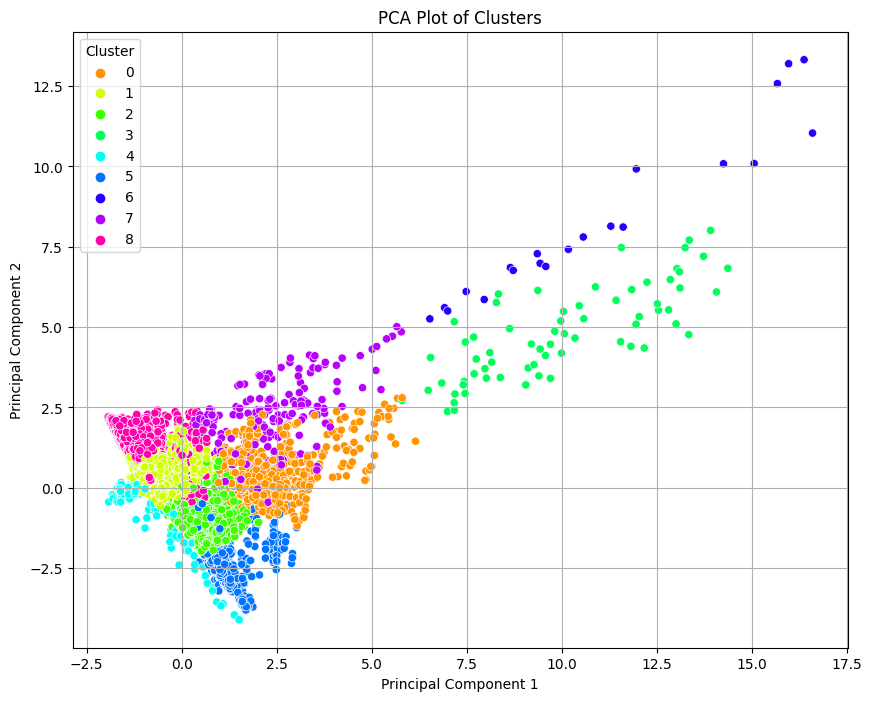

,"Penicillin non-wild-type isolates, percentage_%",R - resistant isolates_N,"R - resistant isolates, percentage _%",S - susceptible isolates_N,Total tested isolates_N,CP_EUR_HAB,EUR_HAB
Cluster,,,,,,,
0,0.031521,517.793103,8.227012,4893.350575,6707.187739,38085.823755,4043.006513
1,0.085036,93.828082,15.293956,331.988376,592.039462,17442.074029,1378.905467
2,0.137095,75.324234,7.148799,495.175136,958.099958,42149.256615,4332.410853
3,0.000000,2326.925373,10.017152,20859.597015,23585.835821,37149.850746,4086.639701
4,19.544092,19.970588,0.000000,269.066176,330.205882,28553.235294,2295.562426
5,0.114789,57.035446,10.273091,362.771214,549.230934,80420.902256,5897.612599
6,0.000000,10651.761905,49.387771,9707.238095,21514.190476,36449.047619,3985.830952
7,0.000000,2813.235955,53.970545,2316.764045,5900.915730,34408.595506,3336.927416
8,0.000000,301.855305,66.194602,127.052090,483.411576,17347.254019,1398.389826


In [4]:
# Since 9 clusters gave the highest silhouette score, we'll use that for the final clustering
kmeans_final = KMeans(n_clusters=9, random_state=42)
merged_data['Cluster'] = kmeans_final.fit_predict(X_scaled)

# Visualizing the clusters using PCA for dimensionality reduction
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Creating a scatter plot of the two principal components colored by cluster
plt.figure(figsize=(10, 8))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=merged_data['Cluster'], palette=sns.color_palette("hsv", 9), legend='full')
plt.title('PCA Plot of Clusters')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Cluster')
plt.grid(True)
plt.show()

# Let's examine the mean values of the features for each cluster
cluster_characteristics = merged_data.groupby('Cluster')[features].mean()
cluster_characteristics


/Users/namirsacic/Library/Python/3.9/lib/python/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


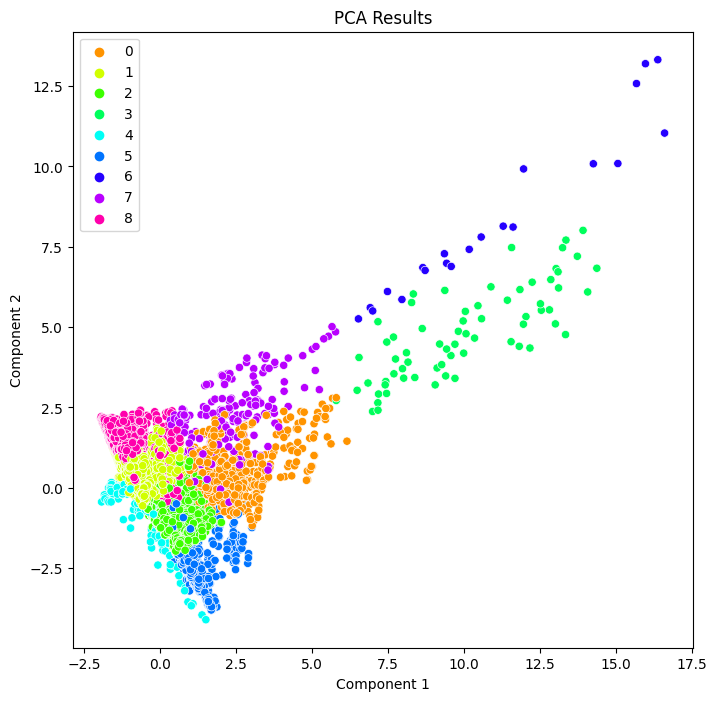

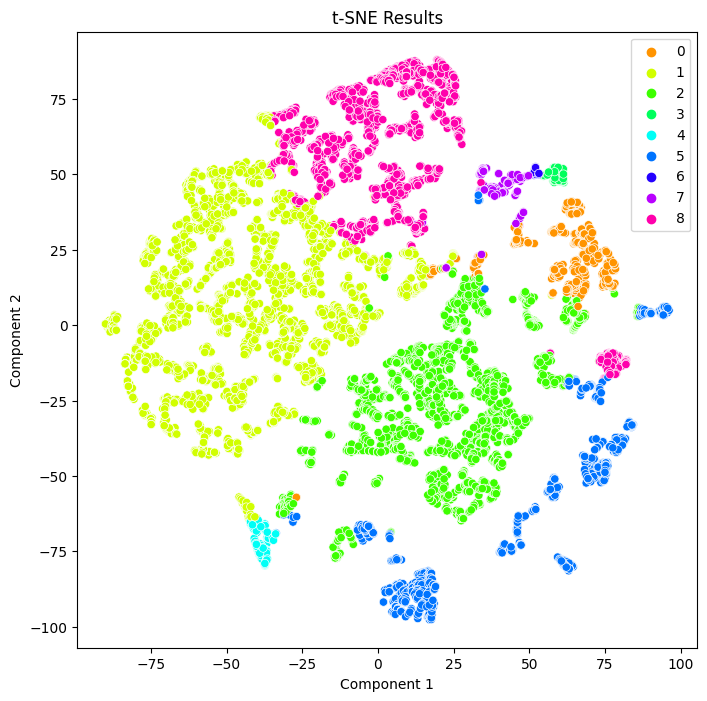

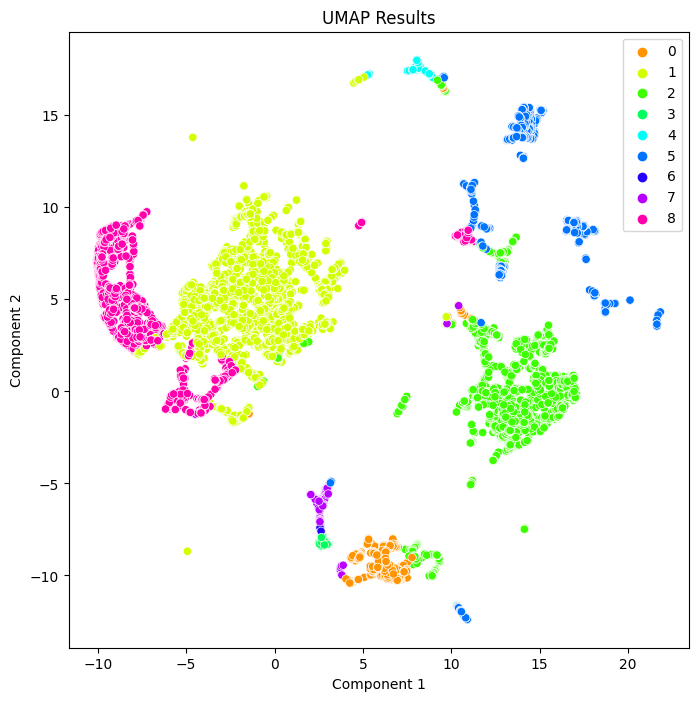

In [11]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import umap

# We will use the scaled data 'X_scaled' from before

# PCA Implementation
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# t-SNE Implementation
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X_scaled)

# UMAP Implementation
umap_model = umap.UMAP(n_neighbors=15, min_dist=0.1, n_components=2, random_state=42)
X_umap = umap_model.fit_transform(X_scaled)

# Now let's visualize the results
import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np

def plot_dimension_reduction(X, title='Dimension Reduction', labels=None):
    plt.figure(figsize=(8, 8))
    sns.scatterplot(x=X[:, 0], y=X[:, 1], hue=labels, 
                    palette=sns.color_palette("hsv", len(np.unique(labels))))
    plt.title(title)
    plt.xlabel('Component 1')
    plt.ylabel('Component 2')
    plt.legend()
    plt.show()

# Make sure to call this function with the labels parameter correctly assigned to your cluster labels.


# Plot the PCA results
plot_dimension_reduction(X_pca, 'PCA Results', labels=merged_data['Cluster'])

# Plot the t-SNE results
plot_dimension_reduction(X_tsne, 't-SNE Results', labels=merged_data['Cluster'])

# Plot the UMAP results
plot_dimension_reduction(X_umap, 'UMAP Results', labels=merged_data['Cluster'])


In [9]:
import numpy as np